[View in Colaboratory](https://colab.research.google.com/github/kobybibas/FittingRandomDataToResnetCNN/blob/master/ProcessingWeightsGPU.ipynb)

In [1]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
import matplotlib.pyplot as plot
import os
import math
import time
import copy
import numpy as np
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

print(torch.__version__)
print(torch.cuda.is_available())

    92% |█████████████████████████████▋  | 547.8MB 48.6MB/s eta 0:00:01

    100% |████████████████████████████████| 592.3MB 35.7MB/s 
  Found existing installation: torch 0.4.0
    Uninstalling torch-0.4.0:
      Successfully uninstalled torch-0.4.0
0.3.0.post4
True


In [2]:
!ls
from google.colab import files
uploaded = files.upload() # then browse, select the files. It's then uploaded

data
datalab
Model_corruptiton_0.0_Acc-tr_99.98 (1).pt
Model_corruptiton_0.0_Acc-tr_99.98.pt
Model_corruptiton_1.0_Acc-tr_10.24.pt
Model_corruptiton_1.0_Acc-tr_99.76 (1).pt
Model_corruptiton_1.0_Acc-tr_99.76.pt


In [0]:
#Define the network
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                                padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                                padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
            out = self.conv1(x)
        else:
            out = self.conv1(self.relu1(self.bn1(x)))

        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(self.relu2(self.bn2(out)))
        if not self.equalInOut:
            return torch.add(self.convShortcut(x), out)
        else:
            return torch.add(x, out)


class NetworkBlock(nn.Module):
        def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
            super(NetworkBlock, self).__init__()
            self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

        def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
            layers = []
            for i in range(nb_layers):
                layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
            return nn.Sequential(*layers)

        def forward(self, x):
            return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, drop_rate=0.0, init_scale=1.0):
        super(WideResNet, self).__init__()

        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                                padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(
            n, nChannels[0], nChannels[1], block, 1, drop_rate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, drop_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, init_scale * math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

                size = m.weight.size()
                fan_out = size[0] # number of rows
                fan_in = size[1] # number of columns
                variance = math.sqrt(2.0/(fan_in + fan_out))
                m.weight.data.normal_(0.0, init_scale * variance)


    def forward(self, x):
        out = self.forward_repr(x)
        return self.fc(out)

    def forward_repr(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return out

In [4]:
# Load weights
!ls
model_real_labels   = torch.load('Model_corruptiton_0.0_Acc-tr_99.98.pt')
model_random_labels = torch.load('Model_corruptiton_1.0_Acc-tr_99.76.pt')

data
datalab
Model_corruptiton_0.0_Acc-tr_99.98 (1).pt
Model_corruptiton_0.0_Acc-tr_99.98.pt
Model_corruptiton_1.0_Acc-tr_10.24.pt
Model_corruptiton_1.0_Acc-tr_99.76 (1).pt
Model_corruptiton_1.0_Acc-tr_99.76.pt


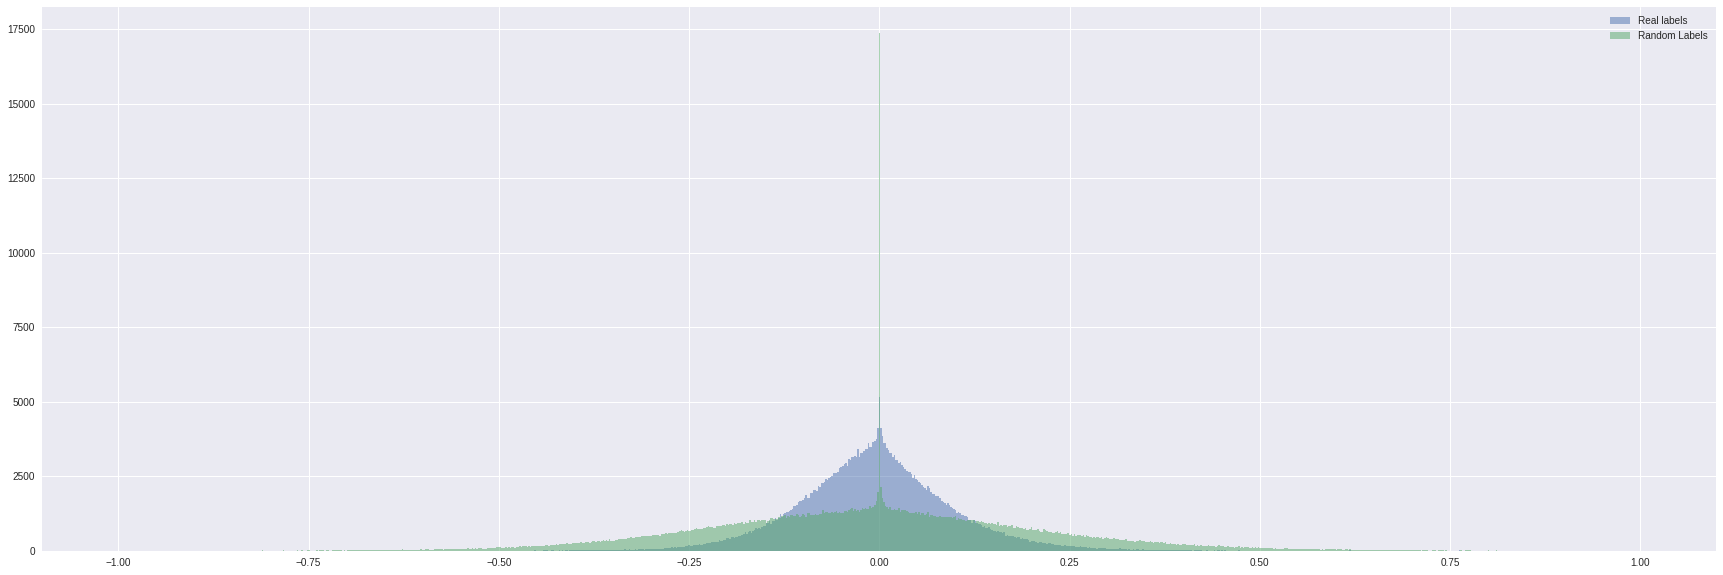

In [5]:
import matplotlib.pyplot as plt
from pylab import rcParams
def extract_model_parameters_to_array(model):
    parameters_array = np.array([])
    for name, param in model.cpu().named_parameters():
        if param.requires_grad:
            flattened_param = param.data.numpy().flatten()
            parameters_array = np.append(parameters_array, flattened_param)
    return parameters_array

# Convert from torch to numpy array
parameters_real_labels    =  extract_model_parameters_to_array(model_real_labels)
parameters_random_labels  =  extract_model_parameters_to_array(model_random_labels) 

# Round to 4 decim
parameters_real_labels   = parameters_real_labels.round(decimals=4)
parameters_random_labels = parameters_random_labels.round(decimals=4)


# Plot histogram of the weights
rcParams['figure.figsize'] = 30, 10
bins = np.linspace(-1, 1, 1000)
plt.hist(parameters_real_labels, bins, alpha=0.5, label='Real labels')
plt.hist(parameters_random_labels, bins, alpha=0.5, label='Random Labels')
plt.legend(loc='upper right')
plt.show()

#plt.subplot(3,1,1)
#plt.hist(parameters_real_labels, bins='auto')
#plt.title("Histogram- Real labels")
#axes = plt.gca()
#axes.set_xlim([-1,1])
#plt.subplot(3,1,2)
#plt.hist(parameters_gaussain_init, bins='auto')
#plt.title("Histogram- Random Gaussian Initialization")
#axes = plt.gca()
#axes.set_xlim([-1,1])
#plt.subplot(3,1,3)
#plt.hist(parameters_random_labels, bins='auto')
#plt.title("Histogram- Random Labels")
#axes = plt.gca()
#axes.set_xlim([-1,1])
#plt.show()

In [6]:
def entropy(X):
    probs = [np.mean(X == c) for c in set(X)]
    return np.sum(-p * np.log2(p) for p in probs)

# Compute the entorpy for each setss of weights
start_time = time.time()
entropy_real_labels = entropy(parameters_real_labels)
print('Entropy real labels = %f, time=%f [sec]' % (entropy_real_labels, time.time() - start_time ))
entropy_random_labels = entropy(parameters_random_labels)
print('Entropy random labels = %f, time=%f [sec]' % (entropy_random_labels, time.time() - start_time ))

Entropy real labels = 12.026414, time=6.057739 [sec]
Entropy random labels = 12.943937, time=16.146453 [sec]


# Evaluate training acuracy

In [0]:
# Define general functions

class CIFAR10RandomLabels(datasets.CIFAR10):
    """CIFAR10 dataset, with support for randomly corrupt labels.

    Params
    ------
    corrupt_prob: float
        Default 0.0. The probability of a label being replaced with
        random label.
    num_classes: int
        Default 10. The number of classes in the dataset.
    """
    def __init__(self, corrupt_prob=0.0, num_classes=10, **kwargs):
        super(CIFAR10RandomLabels, self).__init__(**kwargs)
        self.n_classes = num_classes
        if corrupt_prob > 0:
            self.corrupt_labels(corrupt_prob)

    def corrupt_labels(self, corrupt_prob):
        labels = np.array(self.train_labels if self.train else self.test_labels)
        np.random.seed(12345)
        mask = np.random.rand(len(labels)) <= corrupt_prob
        rnd_labels = np.random.choice(self.n_classes, mask.sum())
        labels[mask] = rnd_labels
        # we need to explicitly cast the labels from npy.int64 to
        # builtin int type, otherwise pytorch will fail...
        labels = [int(x) for x in labels]

        if self.train:
            self.train_labels = labels
        else:
            self.test_labels = labels

            
def get_data_loaders(args, shuffle_train=True):

    # Normalization for CIFAR10
    normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

    if args['data_augmentation']==True:
        transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          normalize,
          ])
    else:
        transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize,
          ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
        ])

    kwargs = {'num_workers': 1, 'pin_memory': True}
    train_loader = torch.utils.data.DataLoader(
        CIFAR10RandomLabels(root='./data', train=True, download=True,
                            transform=transform_train, num_classes=args['num_classes'],
                            corrupt_prob=args['label_corrupt_prob']),
        batch_size=args['batch_size'], shuffle=shuffle_train, **kwargs)
    val_loader = torch.utils.data.DataLoader(
        CIFAR10RandomLabels(root='./data', train=False,
                            transform=transform_test, num_classes=args['num_classes'],
                            corrupt_prob=args['label_corrupt_prob']),
        batch_size=args['batch_size'], shuffle=False, **kwargs)
    
    # Labels of CIFAR10 dataset
    label_translation = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
                         'horse', 'ship', 'truck']

    return train_loader, val_loader, label_translation

In [0]:
# Define general functions for training
def validate_epoch(val_loader, model, criterion, epoch, args):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    for i, (input, target) in enumerate(val_loader):
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

    return losses.avg, top1.avg


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def adding_noise_to_model(model, sigma=1.0):
    noisy_model = copy.deepcopy(model)
    for param in noisy_model.parameters():
        param.data = param.data.add_(np.random.randn()*sigma)
    return noisy_model


In [57]:
# Define hyperparameters
args = {}
args['num_classes'] = 10 
args['data_augmentation'] = False 
args['label_corrupt_prob'] = 0.0
args['batch_size'] = 128


# Load model
labels_state = [True, False]
real_labels = False

for real_labels in labels_state:
    print('Label state: real_labels=%d' % (real_labels) )
    if real_labels == True:
        args['label_corrupt_prob'] = 0.0 # replace with 1.0 for totaly random labels
        model = model_real_labels
    else:
        args['label_corrupt_prob'] = 1.0 # replace with 1.0 for totaly random labels
        model = model_random_labels

    model = torch.nn.DataParallel(model).cuda()
    model = model.cuda() 

    # Load the data
    train_loader, val_loader, label_translation = get_data_loaders(args, shuffle_train=True)

    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().cuda()

    # Iterate on ephoces
    sigma_list = list(np.linspace(0.0001, 0.02, num=50))
    #sigma_list = [0.0001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
    train_accuracy_list = []
    for idx, sigma in enumerate(sigma_list):
        model_with_noise = adding_noise_to_model(model, sigma)

        epoch_time_start = time.time()
        tr_loss, tr_prec1 = validate_epoch(train_loader, model_with_noise, criterion, epoch, args)
        epoch_time = time.time() - epoch_time_start

        train_accuracy_list.append(tr_prec1)

        print('%d/%d: Acc-tr: %6.2f, L-tr: %6.4f, Sigma=%f Time=%10.4f'%(idx, len(sigma_list), tr_prec1, tr_loss, sigma, epoch_time))    

    if real_labels == True:
        train_accuracy_list_real_label = train_accuracy_list
    else:
        train_accuracy_list_random_label = train_accuracy_list

Label state: real_labels=1
Files already downloaded and verified
0/50: Acc-tr:  99.98, L-tr: 0.0051, Sigma=0.000100 Time=   15.2288
1/50: Acc-tr:  99.96, L-tr: 0.0072, Sigma=0.000506 Time=   15.4381
2/50: Acc-tr:  99.92, L-tr: 0.0080, Sigma=0.000912 Time=   15.5663
3/50: Acc-tr:  99.92, L-tr: 0.0081, Sigma=0.001318 Time=   15.5809
4/50: Acc-tr:  99.89, L-tr: 0.0059, Sigma=0.001724 Time=   15.5323
5/50: Acc-tr:  98.22, L-tr: 0.0512, Sigma=0.002131 Time=   15.6962
6/50: Acc-tr:  98.06, L-tr: 0.0571, Sigma=0.002537 Time=   15.6473
7/50: Acc-tr:  99.65, L-tr: 0.0126, Sigma=0.002943 Time=   15.7446
8/50: Acc-tr:  89.87, L-tr: 0.3385, Sigma=0.003349 Time=   15.6263
9/50: Acc-tr:  96.93, L-tr: 0.0902, Sigma=0.003755 Time=   15.6783
10/50: Acc-tr:  97.38, L-tr: 0.0808, Sigma=0.004161 Time=   15.6114
11/50: Acc-tr:  77.15, L-tr: 1.7577, Sigma=0.004567 Time=   15.6742
12/50: Acc-tr:  77.21, L-tr: 0.6724, Sigma=0.004973 Time=   15.6716
13/50: Acc-tr:  82.06, L-tr: 0.5617, Sigma=0.005380 Time=   1

1/50: Acc-tr:  99.70, L-tr: 0.0419, Sigma=0.000506 Time=   15.5489
2/50: Acc-tr:  99.39, L-tr: 0.0624, Sigma=0.000912 Time=   15.5735
3/50: Acc-tr:  98.36, L-tr: 0.0994, Sigma=0.001318 Time=   15.6940
4/50: Acc-tr:  96.34, L-tr: 0.1287, Sigma=0.001724 Time=   15.6578
5/50: Acc-tr:  94.94, L-tr: 0.1486, Sigma=0.002131 Time=   15.6189
6/50: Acc-tr:  96.91, L-tr: 0.1039, Sigma=0.002537 Time=   15.6899
7/50: Acc-tr:  98.68, L-tr: 0.1109, Sigma=0.002943 Time=   15.6369
8/50: Acc-tr:  81.15, L-tr: 0.8492, Sigma=0.003349 Time=   15.6547
9/50: Acc-tr:  89.15, L-tr: 0.3082, Sigma=0.003755 Time=   15.6221
10/50: Acc-tr:  74.72, L-tr: 0.7807, Sigma=0.004161 Time=   15.5968
11/50: Acc-tr:  64.34, L-tr: 1.0934, Sigma=0.004567 Time=   15.6223
12/50: Acc-tr:  66.81, L-tr: 0.9385, Sigma=0.004973 Time=   15.6358
13/50: Acc-tr:  88.33, L-tr: 0.3394, Sigma=0.005380 Time=   15.6657
14/50: Acc-tr:  42.84, L-tr: 4.4025, Sigma=0.005786 Time=   15.6722
15/50: Acc-tr:  63.75, L-tr: 1.0923, Sigma=0.006192 Time=

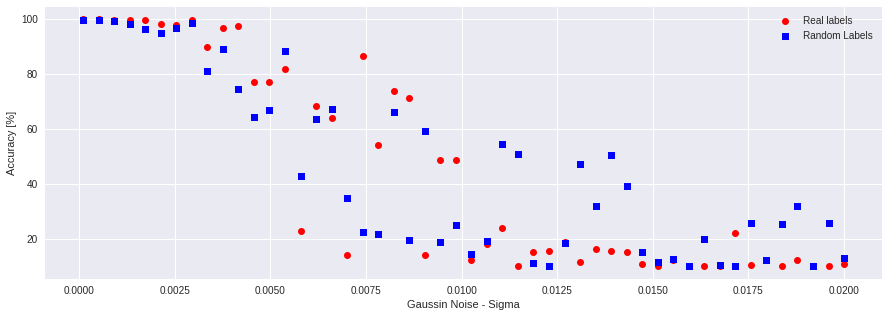

In [59]:
# red dashes, blue squares and green triangles
rcParams['figure.figsize'] = 15, 5
plt.plot(sigma_list, train_accuracy_list_real_label, 'ro', label='Real labels')
plt.plot(sigma_list, train_accuracy_list_random_label, 'bs', label='Random Labels')
plt.xlabel('Gaussin Noise - Sigma')
plt.ylabel('Accuracy [%]')
plt.legend(loc='upper right')
plt.show()